In [36]:
from torch import nn, optim
import numpy as np
import pickle as p
import torch
from tqdm.notebook import trange
from tqdm import tqdm
from torchsummary import summary

from network import ConvNet
from sklearn.metrics import f1_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataset import CogDataset

In [54]:
# function for training and evaluation
def train(model, num_epochs, train_dataloader, val_dataloader):
    losses_train = []
    accuracies_train = []
    f1_train = []
    losses_val = []
    accuracies_val = []
    f1_val = []

    for epoch in trange(num_epochs, unit="epochs"):

        # training
        running_loss = 0.0
        running_accuracy = 0.0
        running_f1 = 0.0

        model.train()

        for input, target in train_dataloader:

            optimizer.zero_grad()

            output = model(input)
            
            loss = criterion(output, target)
            loss.backward()

            running_loss += loss.item()

            prediction = torch.argmax(output, dim=1)


            for p, t in zip(prediction, target):
                if p == t:
                    running_accuracy+=1 
            #running_f1 += f1_score(target, prediction, average=None)
        
        optimizer.step()

        running_loss /= (len(train_dataloader)*batch_size)
        running_accuracy /= (len(train_dataloader) * batch_size)
        #running_f1 /= len(train_dataloader)

        losses_train.append(running_loss)
        accuracies_train.append(running_accuracy)
        #f1_train.append(running_f1)

        # output
        if epoch % 20 == 0:
            tqdm.write('Epoch {} (train) -- loss: {:.4f} acc: {:.4f}'.format(epoch, running_loss, running_accuracy))


        # validation
        with torch.no_grad():

            model.eval()

            running_loss = 0.0
            running_accuracy = 0.0
            running_f1 = 0.0

            for input, target in val_dataloader:

                    output = model(input)
                    loss = criterion(output, target)

                    running_loss += loss.item()

                    prediction = torch.argmax(output, dim=1).float()   

                    for o, t in zip(prediction, target):
                        if o == t:
                            running_accuracy+=1 
                    #running_f1 += f1_score(target, prediction)

            running_loss /= (len(val_dataloader)*batch_size)
            running_accuracy /= (len(val_dataloader)*batch_size)
            #running_f1 /= len(val_dataloader)

            losses_val.append(running_loss)
            accuracies_val.append(running_accuracy)
            #f1_val.append(running_f1)

            # output
            if epoch % 20 == 0:
                tqdm.write('Epoch {} (valid) -- loss: {:.4f} acc: {:.4f}'.format(epoch, running_loss, running_accuracy))
    # make model callable outside this function
    train.trained_model = model
    train.losses_train = losses_train
    train.losses_val = losses_val
    train.accuracy_train = accuracies_train
    train.accuracy_val = accuracies_val

In [55]:
# load data and label files
# shape = [2284, 200, 3, 9] --> [datasets, time series, channels, devices]
data = p.load(open(r"data/train.pkl", "rb"))
labels = p.load(open(r"data/labels.pkl", "rb"))
print(data.shape)

batch_size = 10

# create datasets
train_dataset = CogDataset(data, labels, train=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CogDataset(data, labels, train=False)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


(2284, 8, 200, 3)


In [39]:
label_counts = torch.from_numpy(labels).bincount().float()
weights = np.sqrt(1/label_counts)
weights /= weights.mean()
print(weights)

tensor([0.9987, 0.9867, 0.9752, 0.9867, 0.9230, 0.9867, 0.9867, 0.9428, 0.9327,
        1.4299, 0.9532, 0.9987, 1.0111, 1.0111, 1.0111, 0.9867, 1.0111, 0.9987,
        0.9640, 1.0111, 0.9327, 0.9752, 1.0111, 0.9640, 0.9230, 1.4299, 0.9640,
        0.9987, 0.9640, 0.9987, 0.9640, 1.0240, 0.9987, 0.9752, 0.9752, 0.9428,
        1.0111, 1.0111, 0.9752, 0.9867, 0.9867, 0.9867, 0.9640, 1.0111, 1.0111,
        0.9752, 0.9532, 0.9987, 1.0111, 1.0240, 0.9987, 1.0111, 0.9640, 0.9987,
        0.9752])


In [56]:
# define loss, optimizer etc.
model = ConvNet()
epochs = 250
lr = 0.001
criterion = nn.CrossEntropyLoss(weight = weights.double())
optimizer = optim.Adam(model.parameters(), lr)


In [57]:
# train model
train(model.double(), epochs, train_dataloader, val_dataloader)

  0%|          | 0/250 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.4040 acc: 0.0158
Epoch 0 (valid) -- loss: 0.4035 acc: 0.0152
Epoch 20 (train) -- loss: 0.3888 acc: 0.0443
Epoch 20 (valid) -- loss: 0.3854 acc: 0.0543
Epoch 40 (train) -- loss: 0.3780 acc: 0.0596
Epoch 40 (valid) -- loss: 0.3763 acc: 0.0500
Epoch 60 (train) -- loss: 0.3733 acc: 0.0738
Epoch 60 (valid) -- loss: 0.3711 acc: 0.0609
Epoch 80 (train) -- loss: 0.3690 acc: 0.0847
Epoch 80 (valid) -- loss: 0.3666 acc: 0.0848
Epoch 100 (train) -- loss: 0.3632 acc: 0.0858
Epoch 100 (valid) -- loss: 0.3630 acc: 0.0739
Epoch 120 (train) -- loss: 0.3583 acc: 0.1000
Epoch 120 (valid) -- loss: 0.3568 acc: 0.0957
Epoch 140 (train) -- loss: 0.3559 acc: 0.1180
Epoch 140 (valid) -- loss: 0.3533 acc: 0.1196


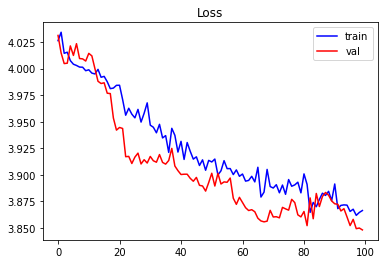

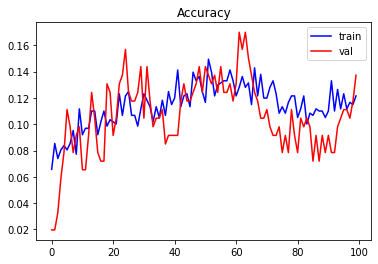

In [43]:
import matplotlib.pyplot as plt

plt.plot(np.arange(epochs), train.losses_train, color="b", label="train")
plt.plot(np.arange(epochs), train.losses_val, color="r", label="val")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(np.arange(epochs), train.accuracy_train, color="b",label="train" )
plt.plot(np.arange(epochs), train.accuracy_val, color="r",label="val")
plt.title("Accuracy")
plt.legend()
plt.show()